In [10]:
import pandas as pd

nifty200_df = pd.read_csv('nifty200.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty200_df.Symbol.tolist()]

In [11]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data_1D = load_stock_data(file_paths, data_path, "1D")

Loading 1Dmin data: 100%|██████████| 200/200 [00:00<00:00, 797.58it/s]


In [12]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

interval = 5

data_path = f"../data{interval}m"

end_date = dt.datetime.now()
start_date = dt.datetime(2020, 1, 1)

file_paths = prepare_data(tickers, f"{interval}", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data_5m = load_stock_data(file_paths, data_path, f"{interval}")

Loading 5min data: 100%|██████████| 200/200 [00:00<00:00, 238.58it/s]


In [13]:
df = pd.concat(loaded_data_1D, names=["Stock", "Date"]).reset_index()
df = df[df.Date <= '2026-08-11 05:30:00']

df5m = pd.concat(loaded_data_5m, names=["Stock", "Date"]).reset_index()
df5m = df5m[df5m.Date <= '2026-08-11 05:30:00']

In [14]:
df5m = df5m[df5m.Date >= '2025-01-01 05:30:00'].reset_index(drop=True)
# df5m = df5m.groupby('Stock').resample('15T', on='Date').agg({
#     'Open': 'first',
#     'Low': 'min',
#     'High': 'max',
#     'Close': 'last',
#     'Volume': 'sum'
# })

In [15]:
import talib as ta


price_band = 0.02
df = df5m

# Calculate RSI per stock
df['SMA5'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=5))
df['SMA20'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=20))
df['SMA50'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=50))
df['SMA100'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=100))
df['SMA200'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=200))

df['VOL_SMA20'] = df.groupby('Stock')['Volume'].transform(lambda x: ta.SMA(x, timeperiod=20))

df['upper_threashold'] = df.Close * (1 + price_band)
df['lower_threashold'] = df.Close * (1 - price_band)

df['Entry_Price'] = df.groupby('Stock')['Close'].shift(-1)
df['Entry_Time'] = df.groupby('Stock')['Date'].shift(-1)
df['NxtHigh'] = df.groupby('Stock')['High'].shift(-1)
df['NxtClose'] = df.groupby('Stock')['Close'].shift(-1)
df['NxtOpen'] = df.groupby('Stock')['Open'].shift(-1)
df['NxtVOL_SMA20'] = df.groupby('Stock')['VOL_SMA20'].shift(-1)


In [16]:
signals = (
    df[
        (df.upper_threashold > df.SMA5) & (df.lower_threashold < df.SMA5) &
        (df.upper_threashold > df.SMA20) & (df.lower_threashold < df.SMA20) &
        (df.upper_threashold > df.SMA50) & (df.lower_threashold < df.SMA50) &
        (df.upper_threashold > df.SMA100) & (df.lower_threashold < df.SMA100) &
        (df.upper_threashold > df.SMA200) & (df.lower_threashold < df.SMA200)
        # (df.NxtClose >= df.upper_threashold) &
        # (df.NxtVOL_SMA20/df.VOL_SMA20 >= 1.5)
    ]
)
signals = signals.sort_values(['Date', 'VOL_SMA20'], ascending=[True, False]).groupby('Date').head(3).reset_index(drop=True)

# Backtest

Backtesting...:   0%|          | 0/12375 [00:00<?, ?it/s]

Already in position for NSE:JIOFIN-EQ
Already in position for NSE:YESBANK-EQ
Already in position for NSE:JIOFIN-EQ
Already in position for NSE:ITC-EQ
Already in position for NSE:JIOFIN-EQ
Already in position for NSE:ITC-EQ
Already in position for NSE:ETERNAL-EQ
Already in position for NSE:YESBANK-EQ
Already in position for NSE:IREDA-EQ
Already in position for NSE:JIOFIN-EQ
Already in position for NSE:YESBANK-EQ
Already in position for NSE:IREDA-EQ
Already in position for NSE:JIOFIN-EQ
Already in position for NSE:YESBANK-EQ
Already in position for NSE:IREDA-EQ
Already in position for NSE:JIOFIN-EQ
Already in position for NSE:YESBANK-EQ
Already in position for NSE:IREDA-EQ
Already in position for NSE:JIOFIN-EQ
Already in position for NSE:YESBANK-EQ
Already in position for NSE:JIOFIN-EQ
Already in position for NSE:YESBANK-EQ
Already in position for NSE:JIOFIN-EQ
Already in position for NSE:IREDA-EQ
Already in position for NSE:YESBANK-EQ
Already in position for NSE:JIOFIN-EQ
Already in pos

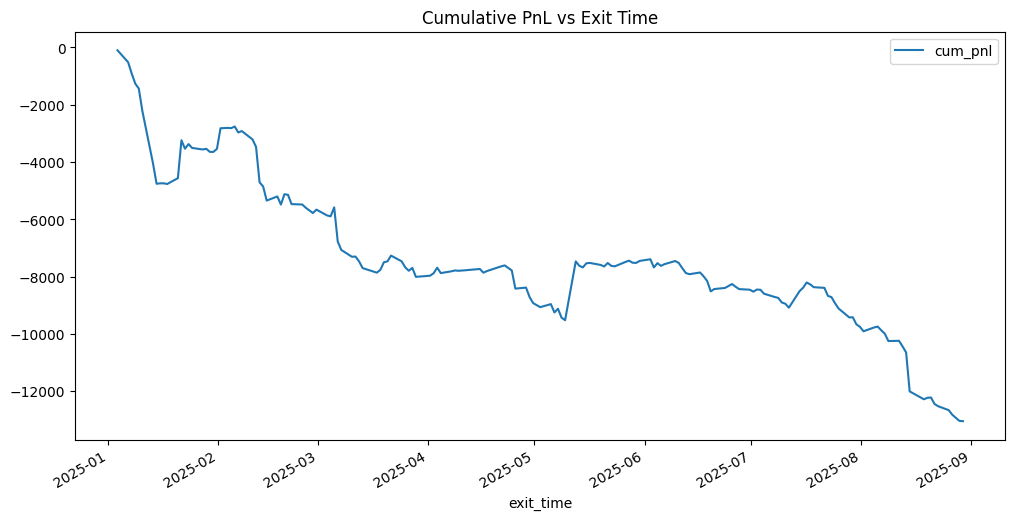

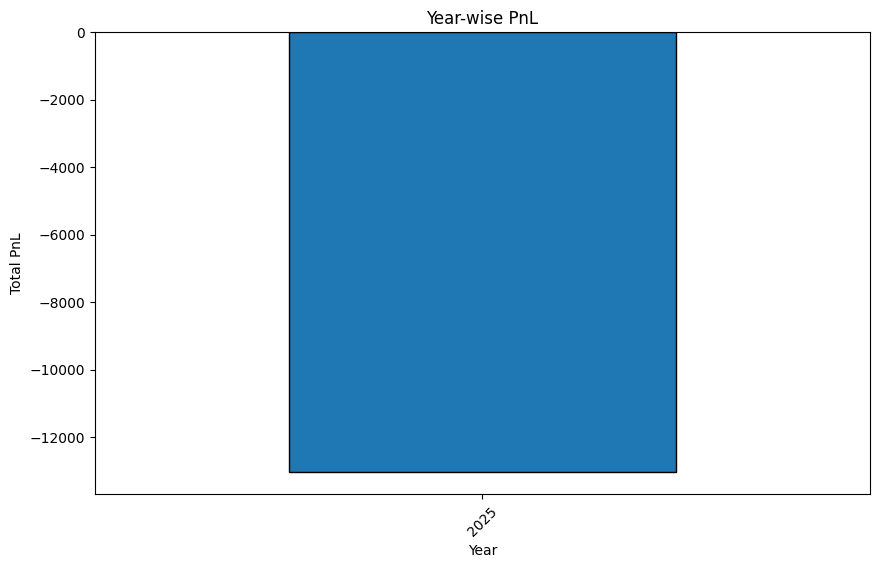

In [18]:
from lib import Bank, PositionManager, show_equity_curve, generate_tearsheet
from tqdm.notebook import tqdm

leverage = 1
initial_capital = 100000
max_positions = 10
tp_perc = 4
sl_perc = 2
intraday = True

def book_profit(pm: PositionManager, row):
    global active_positions, closed_positions, bank
    for position in pm.get_active_positions():
        stock_data = row[(row.Stock == position.stock)]
        if stock_data.empty:
            continue
        stock_data = stock_data.iloc[0]

        if stock_data.Date.time() == dt.time(15, 10):
            pm.close_position(position.stock, stock_data.Date, stock_data.Close)
            return
        if stock_data.High >= position.tp:
            pm.close_position(position.stock, stock_data.Date, position.tp)
            return
        if stock_data.Low <= position.sl:
            pm.close_position(position.stock, stock_data.Date, position.sl)
            return
        

def backtest(pm: PositionManager, tp_perc=tp_perc, sl_perc=sl_perc):
    global active_positions, closed_positions, bank, max_positions
    pb = tqdm(total=df.Date.nunique(), desc="Backtesting...")
    for idx, row in df.groupby('Date'):
        if idx.time() <= dt.time(9,30) or idx.time() > dt.time(15,10):
            pb.update(1)
            continue
        day_signals = signals[signals.Entry_Time == idx]
        for signal in day_signals.itertuples():
            if pm.get_position(signal.Stock) is not None:
                print(f"Already in position for {signal.Stock}")
                continue

            if (
                (signal.upper_threashold < row.Low.iloc[0] < row.Close.iloc[0]) 
                    # and (row.VOL_SMA20.iloc[0]/signal.VOL_SMA20 >= 1)
            ):
                capital = round(pm.bank.total_capital()/max_positions, 2)
                position = pm.new_position(signal.Stock, signal.Entry_Time, signal.NxtOpen, capital)
                if position is not None:
                    position.tp = position.avg_entry_price * (1 + tp_perc)
                    position.sl = position.avg_entry_price * (1 - sl_perc)

        book_profit(pm, row)
        pb.update(1)
    pb.close()

    return generate_tearsheet(initial_capital, pm)
                
if __name__ == "__main__":
    bank = Bank(initial_capital)
    pm = PositionManager(bank, leverage=leverage)
    tearsheet, trades = backtest(pm, tp_perc=tp_perc, sl_perc=sl_perc)
    print(pd.DataFrame({
        "Metrics": tearsheet.keys(),
        "Values": tearsheet.values(),
    }))
    show_equity_curve(trades)

In [ ]:
trades.to_csv('trades.csv', index=False)